In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 데이터 불러오기

In [329]:
df_raw = pd.read_csv("rawdata/SCALE불량2.csv", encoding = "CP949")

In [330]:
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC.1
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,116,1133,59,282,1133,934,적용,8,2조,AB
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,122,1135,53,283,1135,937,적용,8,2조,AB
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,116,1121,55,282,1121,889,적용,8,3조,NV
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,125,1127,68,316,1127,885,적용,8,3조,NV
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,134,1128,48,314,1128,873,적용,8,1조,BV


### 전처리

### 범주형 변수 확인

In [6]:
obj_cols = df_raw.select_dtypes("object").columns
for col in obj_cols:
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

PLATE_NO : 720
ROLLING_DATE : 704
SCALE : 2
SPEC : 66
STEEL_KIND : 9
FUR_NO : 3
HSB : 2
WORK_GR : 4
SPEC.1 : 16


In [331]:
# 필요없는 변수 버리기
df_raw = df_raw.drop(["PLATE_NO", "ROLLING_DATE", "FUR_SZ_TEMP"], axis = 1)

In [8]:
obj_cols = df_raw.select_dtypes("object").columns
for col in obj_cols:
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

SCALE : 2
SPEC : 66
STEEL_KIND : 9
FUR_NO : 3
HSB : 2
WORK_GR : 4
SPEC.1 : 16


In [9]:
import numpy as np

In [332]:
# 불량/양품 0과 1로 변경
df_raw["SCALE"] = np.where(df_raw["SCALE"] == "불량", 1, 0)
df_raw["HSB"] = np.where(df_raw["HSB"] == "적용", 1, 0)

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import StandardScaler as sds
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [294]:
df_train, df_test = train_test_split(df_raw, test_size = 0.3, random_state = 1234)
print("train data size\t: {}".format(df_train.shape))
print("test data size\t: {}".format(df_test.shape))

train data size	: (504, 19)
test data size	: (216, 19)


In [295]:
df_raw_lr = df_raw.drop(["SPEC", "SPEC.1"], axis = 1)

In [296]:
df_raw_lr = df_raw_lr.drop(["STEEL_KIND"], axis = 1)

In [297]:
for i in list(df_raw):
    print (i, end = " + ")

SCALE + SPEC + STEEL_KIND + PT_THK + PT_WDTH + PT_LTH + PT_WGT + FUR_NO + FUR_NO_ROW + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TIME + FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + HSB + ROLLING_DESCALING + WORK_GR + SPEC.1 + 

In [51]:
log_model = Logit.from_formula("SCALE ~ PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO) + FUR_NO_ROW + \
                               FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TIME + FUR_TIME + FUR_EXTEMP + \
                               ROLLING_TEMP_T5 + HSB + ROLLING_DESCALING + C(WORK_GR)",  df_train)
log_result = log_model.fit()

         Current function value: 0.258678
         Iterations: 35


/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [52]:
print(log_result.summary())

                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                           18
Date:                Sun, 28 Jul 2019   Pseudo R-squ.:                  0.5861
Time:                        02:02:11   Log-Likelihood:                -130.37
converged:                      False   LL-Null:                       -314.97
                                        LLR p-value:                 2.368e-67
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -81.5822   2.89e+05     -0.000      1.000   -5.67e+05    5.67e+05
C(FUR_NO)[T.2호기]      0.1144      0.397      0.288      0.773      -0.664       0.893
C(FUR_NO)[T.3호기]      0.

In [43]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

146    1
131    1
650    0
613    1
355    0
dtype: int64

In [44]:
print("Accuracy: %.3f \n" % accuracy_score(df_test["SCALE"], y_pred_class))
print("Confusion Matrix:\n{}".format(confusion_matrix(df_test["SCALE"], y_pred_class)))

Accuracy: 0.861 

Confusion Matrix:
[[125  20]
 [ 10  61]]


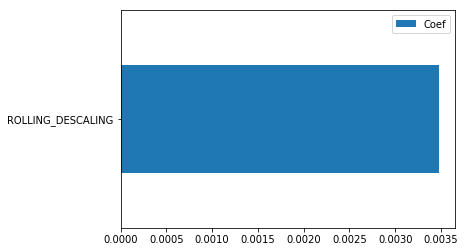

In [47]:
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")

In [58]:
from sklearn.feature_selection import RFE  # Recrusive Factor Elimination << Elminating factors that are not relavant
from sklearn.linear_model import LinearRegression


# decision tree

In [61]:

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [333]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC.1
0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,59,282,1133,934,1,8,2조,AB
1,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,53,283,1135,937,1,8,2조,AB
2,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,55,282,1121,889,1,8,3조,NV
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,68,316,1127,885,1,8,3조,NV
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,48,314,1128,873,1,8,1조,BV


In [334]:
df_raw["SPEC"] = df_raw["SPEC.1"]
df_raw = df_raw.drop(["SPEC.1"], axis = 1)

In [335]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,AB,T1,32.25,3707,15109,14180,1호기,1,1144,116,59,282,1133,934,1,8,2조
1,0,AB,T1,32.25,3707,15109,14180,1호기,2,1144,122,53,283,1135,937,1,8,2조
2,0,NV,T8,33.27,3619,19181,18130,2호기,1,1129,116,55,282,1121,889,1,8,3조
3,0,NV,T8,33.27,3619,19181,18130,2호기,2,1152,125,68,316,1127,885,1,8,3조
4,0,BV,T8,38.33,3098,13334,12430,3호기,1,1140,134,48,314,1128,873,1,8,1조


In [336]:
df_raw = pd.get_dummies(df_raw)

In [338]:
df_raw.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,...,STEEL_KIND_T5,STEEL_KIND_T7,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,59,282,...,0,0,0,1,0,0,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,53,283,...,0,0,0,1,0,0,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,55,282,...,0,0,1,0,1,0,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,68,316,...,0,0,1,0,1,0,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,48,314,...,0,0,1,0,0,1,1,0,0,0


In [339]:
df_train, df_test = train_test_split(df_raw, test_size = 0.3, random_state = 42)
print("Train data size\t: {}".format(df_train.shape))
print("Test data size\t: {}".format(df_test.shape))

Train data size	: (504, 46)
Test data size	: (216, 46)


In [340]:
df_train_x = df_train.drop(["SCALE"], axis = 1)
df_train_y = df_train[["SCALE"]]
df_test_x = df_test.drop(["SCALE"], axis = 1)
df_test_y = df_test[["SCALE"]]

In [341]:
train_accuracy = []; test_accuracy = []
para_depth = [depth for depth in range (1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state = 42)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.887,0.898
1,2,0.931,0.940
2,3,0.962,0.963
3,4,0.968,0.972
4,5,0.972,0.972
5,6,0.974,0.972
6,7,0.974,0.972
7,8,0.980,0.977
8,9,0.984,0.958
9,10,0.986,0.968


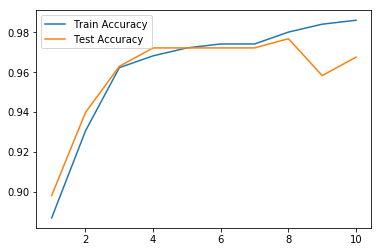

In [342]:
plt.plot(para_depth, train_accuracy, linestyle='-',label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle='-',label="Test Accuracy")
plt.legend()

In [352]:
train_accuracy = []; test_accuracy = []

para_split = [n_split * 10 for n_split in range (1, 11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split,
                                 max_depth = 5, random_state = 42)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.972,0.972
1,20,0.972,0.972
2,30,0.972,0.972
3,40,0.972,0.972
4,50,0.972,0.972
5,60,0.972,0.972
6,70,0.972,0.972
7,80,0.972,0.972
8,90,0.972,0.972
9,100,0.972,0.972


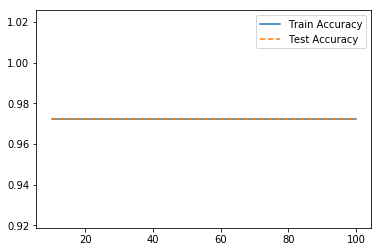

In [350]:
plt.plot(para_split, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [353]:
train_accuracy = []; test_accuracy = []

para_leaf = [n_leaf * 2 for n_leaf in range (1, 11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, min_samples_split = 40, 
                                  max_depth = 5, random_state = 42)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.972,0.972
1,4,0.984,0.981
2,6,0.984,0.981
3,8,0.984,0.981
4,10,0.984,0.981
5,12,0.968,0.972
6,14,0.968,0.972
7,16,0.968,0.972
8,18,0.964,0.968
9,20,0.960,0.949


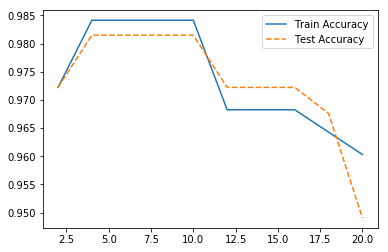

In [354]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [358]:
tree_final = DecisionTreeClassifier(max_depth = 5, min_samples_split = 40, min_samples_leaf = 10, random_state = 42)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=40,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

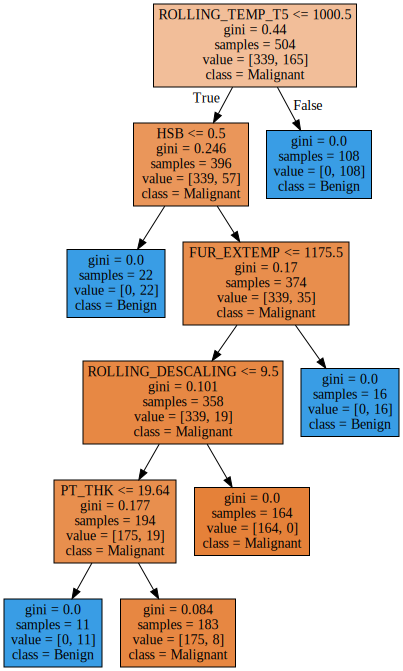

In [359]:
v_feature_name = df_train_x.columns
export_graphviz(tree_final, out_file = "tree_final.dot", class_names =["Malignant", "Benign"],
                feature_names = v_feature_name, impurity = True, filled = True) 

with open("tree_final.dot") as f:
    dot_graph = f.read()
    
display(graphviz.Source(dot_graph))

## decision tree 결과

In [361]:

y_pred = tree_final.predict(df_train_x)
print("Train set accuracy: %.3f" % tree_final.score(df_train_x, df_train_y))
print("Confusion matirx\n{}".format(confusion_matrix(df_train_y, y_pred)))


y_pred = tree_final.predict(df_test_x)
print("Test set accuracy: %.3f" % tree_final.score(df_test_x, df_test_y))
cfm = confusion_matrix(df_test_y, y_pred)
print("Confusion matirx\n{}".format(cfm))


Train set accuracy: 0.984
Confusion matirx
[[339   0]
 [  8 157]]
Test set accuracy: 0.981
Confusion matirx
[[150   0]
 [  4  62]]


In [362]:
df_importance = pd.DataFrame()
df_importance["feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,feature,Importance
10,ROLLING_TEMP_T5,0.602
11,HSB,0.165
9,FUR_EXTEMP,0.133
0,PT_THK,0.092
12,ROLLING_DESCALING,0.008
40,FUR_NO_3호기,0.000
34,STEEL_KIND_T3,0.000
27,SPEC_SA283,0.000
28,SPEC_V42JBN3,0.000
29,STEEL_KIND_C0,0.000


## feature importance

In [363]:
df_importance = df_importance.sort_values(by=["Importance"], ascending = False)
df_importance = df_importance.reset_index()

Text(0, 0.5, '설명번수')

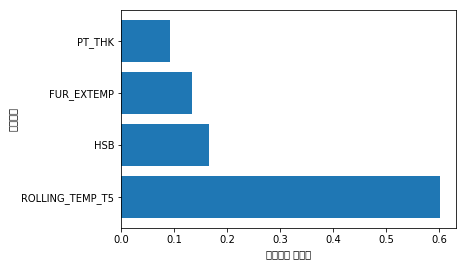

In [364]:
#df_importance.sort_values("Importance", ascending=True, inplace = True)

coordinates = range(len(df_importance) - 41)
plt.barh(y = coordinates, width = df_importance["Importance"][:4])
plt.yticks(coordinates, df_importance["feature"][:4])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명번수")

In [172]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Gradient Boosting

In [365]:
rf_uncustomized = GradientBoostingClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

# 과대적합

Accuracy on training set: 1.000
Accuracy on test set: 0.991


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [366]:
train_accuracy = []; test_accuracy = []

para_lr = [lr * 0.1 for lr in range (1, 30)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

df_accuracy_lr.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,1.000,0.991
1,0.2,1.000,1.000
2,0.3,1.000,1.000
3,0.4,1.000,0.995
4,0.5,1.000,0.995
5,0.6,1.000,0.977
6,0.7,1.000,0.986
7,0.8,1.000,0.995
8,0.9,1.000,0.981
9,1.0,1.000,0.977


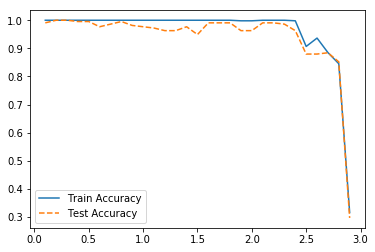

In [367]:
plt.plot(para_lr, train_accuracy, linestyle = '-', label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = '--', label = "Test Accuracy")
plt.legend()

In [368]:
train_accuracy = []; test_accuracy = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 30)]

for v_n_estimator in para_n_tree:
    rf = GradientBoostingClassifier(learning_rate = 1.6, n_estimators = v_n_estimator, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimator"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

df_accuracy_n.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

,n_estimator,TrainAccuracy,TestAccuracy
0,10,1.0,0.991
1,20,1.0,0.991
2,30,1.0,0.991
3,40,1.0,0.991
4,50,1.0,0.991
5,60,1.0,0.991
6,70,1.0,0.991
7,80,1.0,0.991
8,90,1.0,0.991
9,100,1.0,0.991


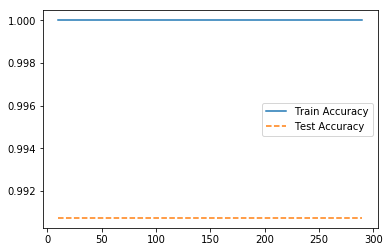

In [369]:
plt.plot(para_n_tree, train_accuracy, linestyle = '-', label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = '--', label = "Test Accuracy")
plt.legend()

In [370]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range (1, 21)]

for v_max_depth in para_depth:
    rf = GradientBoostingClassifier(learning_rate = 1.6, n_estimators = 100, max_depth = v_max_depth, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

df_accuracy_depth.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

,Depth,TrainAccuracy,TestAccuracy
0,1,0.986,0.977
1,2,1.000,0.972
2,3,1.000,0.991
3,4,1.000,0.995
4,5,1.000,0.977
5,6,1.000,0.981
6,7,1.000,0.986
7,8,1.000,0.972
8,9,1.000,0.944
9,10,1.000,0.949


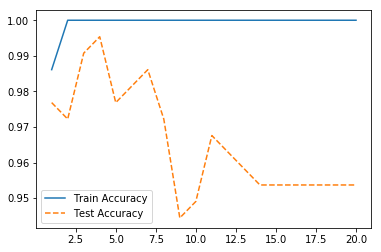

In [371]:
plt.plot(para_depth, train_accuracy, linestyle = '-', label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = '--', label = "Test Accuracy")
plt.legend()

In [372]:
train_accuracy = []; test_accuracy = []

para_split = [n_split * 10 for n_split in range (2, 16)]

for v_min_samples_split in para_split:
    rf = GradientBoostingClassifier(min_samples_split = v_min_samples_split, learning_rate = 1.6, n_estimators = 100, 
                                    max_depth = 3, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

df_accuracy_split.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,1.0,0.991
1,30,1.0,0.991
2,40,1.0,0.991
3,50,1.0,0.991
4,60,1.0,0.991
5,70,1.0,0.991
6,80,1.0,0.991
7,90,1.0,0.991
8,100,1.0,0.991
9,110,1.0,0.991


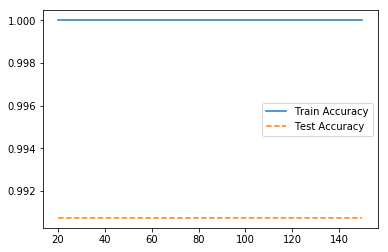

In [373]:
plt.plot(para_split, train_accuracy, linestyle = '-', label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = '--', label = "Test Accuracy")
plt.legend()

In [376]:
train_accuracy = []; test_accuracy = []

para_leaf = [n_leaf * 10 for n_leaf in range (1, 16)]

for v_min_samples_leaf in para_leaf:
    rf = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf, min_samples_split = 60, learning_rate = 1.6, 
                                    n_estimators = 100, max_depth = 3, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesSplit"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

df_accuracy_leaf.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,1.000,0.991
1,20,0.998,0.968
2,30,1.000,0.870
3,40,1.000,0.880
4,50,1.000,0.889
5,60,1.000,0.884
6,70,1.000,0.884
7,80,1.000,0.912
8,90,1.000,0.903
9,100,1.000,0.903


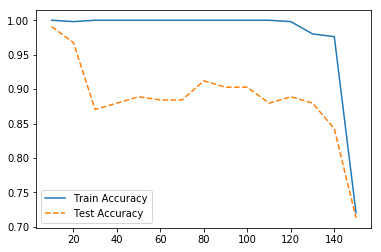

In [377]:
plt.plot(para_leaf, train_accuracy, linestyle = '-', label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = '--', label = "Test Accuracy")
plt.legend()

## Boosting Tree 결과

In [379]:
gb_final = GradientBoostingClassifier(min_samples_leaf = 5, min_samples_split = 80, learning_rate = 1.6, 
                                    n_estimators = 100, max_depth = 3, random_state = 1234)

gb_final.fit(df_train_x, df_train_y)

y_pred = gb_final.predict(df_test_x)

print("Accuracy on training set: %.3f" % gb_final.score(df_train_x, df_train_y))
print("Accuracy on test set\t: %.3f" % gb_final.score(df_test_x, df_test_y))
print("Confusion matrix")
print(confusion_matrix(df_test_y, y_pred))

Accuracy on training set: 0.998
Accuracy on test set	: 0.986
Confusion matrix
[[150   0]
 [  3  63]]


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [380]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
10,ROLLING_TEMP_T5,0.636
11,HSB,0.143
9,FUR_EXTEMP,0.115
12,ROLLING_DESCALING,0.066
0,PT_THK,0.016
32,STEEL_KIND_T0,0.015
33,STEEL_KIND_T1,0.007
7,FUR_SZ_TIME,0.001
5,FUR_HZ_TEMP,0.001
19,SPEC_GL,0.000


Text(0, 0.5, 'Feature')

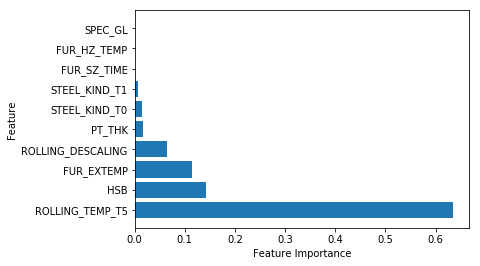

In [381]:
df_importance = df_importance.sort_values(by=["Importance"], ascending = False)
df_importance = df_importance.reset_index()
coordinates = range(len(df_importance) - 35)
plt.barh(y = coordinates, width = df_importance["Importance"][:10])
plt.yticks(coordinates, df_importance["Feature"][:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

# random forest

In [210]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

## 언커스텀

In [382]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

# 과대적합

Accuracy on training set: 0.996
Accuracy on test set: 0.931


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [383]:
train_accuracy = []; test_accuracy = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimator in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimator, random_state = 1234)
    rf.fit(df_train_x, df_train_y.values.ravel())
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimator"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

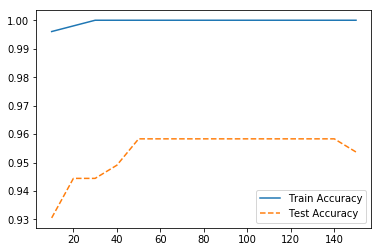

In [384]:
plt.plot(para_n_tree, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

In [231]:
selected_estimator = 120

In [385]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range (1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(n_estimators = 120, max_depth = v_max_depth, random_state = 1234)
    rf.fit(df_train_x, df_train_y.values.ravel())
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.738,0.713
1,2,0.885,0.894
2,3,0.903,0.903
3,4,0.915,0.903
4,5,0.954,0.931
5,6,0.966,0.954
6,7,0.980,0.954
7,8,0.988,0.963
8,9,0.994,0.963
9,10,0.998,0.963


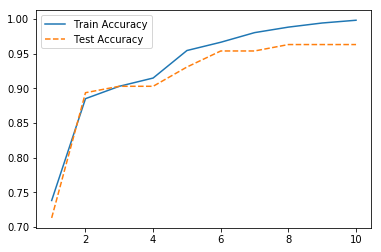

In [386]:
plt.plot(para_depth, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

In [387]:
train_accuracy = []; test_accuracy = []

para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split, n_estimators = 120, max_depth = 6, 
                                random_state = 1234)
    rf.fit(df_train_x, df_train_y.values.ravel())
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.966,0.944
1,20,0.954,0.940
2,30,0.952,0.944
3,40,0.946,0.940
4,50,0.937,0.940
5,60,0.942,0.940
6,70,0.938,0.935
7,80,0.933,0.935
8,90,0.929,0.940
9,100,0.919,0.940


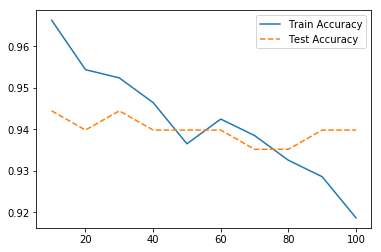

In [388]:
plt.plot(para_split, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

## result

In [397]:
rf_final = RandomForestClassifier(min_samples_leaf = 5, min_samples_split = 20, 
                                n_estimators = 120, max_depth = 6, random_state = 42)

rf_final.fit(df_train_x, df_train_y.values.ravel())
y_pred = rf_final.predict(df_test_x)

print("Accuracy on")
print("Uncustomzed\t training: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Uncustomzed\t test\t : {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))
print("Tunned\t\t training: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Tunned\t\t test\t : {:.3f}".format(rf_final.score(df_test_x, df_test_y)))


Accuracy on
Uncustomzed	 training: 0.996
Uncustomzed	 test	 : 0.931
Tunned		 training: 0.938
Tunned		 test	 : 0.940


In [398]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.head().round(3)

,Feature,Importance
10,ROLLING_TEMP_T5,0.326
9,FUR_EXTEMP,0.117
1,PT_WDTH,0.068
11,HSB,0.061
0,PT_THK,0.056


## feature iptc

Text(0, 0.5, 'Feature')

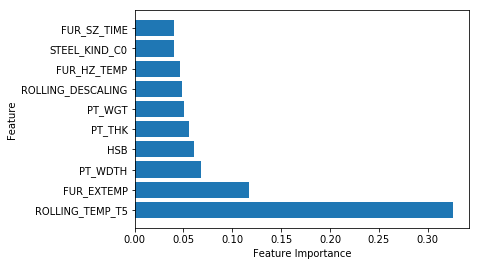

In [399]:
coordinates = range(len(df_importance) - 35)
plt.barh(y = coordinates, width = df_importance["Importance"][:10])
plt.yticks(coordinates, df_importance["Feature"][:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

# SVM

In [400]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [401]:
svc_uncustomized = SVC(random_state=1234, gamma = 'auto')
svc_uncustomized.fit(df_train_x, df_train_y.values.ravel())

print("Accuracy on training set: {:.3f}".format(svc_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svc_uncustomized.score(df_test_x, df_test_y)))

# 과대적합

Accuracy on training set: 1.000
Accuracy on test set: 0.694


In [402]:
svm_uncustomized = SVC(random_state=1234, gamma = 'scale')
svm_uncustomized.fit(df_train_x, df_train_y.values.ravel())

print("Accuracy on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

# 과대적합

Accuracy on training set: 0.673
Accuracy on test set: 0.694


In [403]:
df_raw_x = df_raw.drop(["SCALE"], axis = 1)

In [404]:
v_feature_name = df_train_x.columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_name)
df_scaled.head()

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,...,STEEL_KIND_T5,STEEL_KIND_T7,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.544097,-0.409268,-0.949149,...,-0.252023,-0.226042,-0.389872,1.414214,-0.700488,-0.713746,-0.596601,1.834022,-0.56024,-0.607307
1,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.708951,-0.387221,-0.835252,...,-0.252023,-0.226042,-0.389872,1.414214,-0.700488,-0.713746,-0.596601,1.834022,-0.56024,-0.607307
2,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-0.654000,-0.409268,-1.632537,...,-0.252023,-0.226042,2.564946,-0.707107,1.427577,-0.713746,-0.596601,-0.545250,1.78495,-0.607307
3,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-0.296815,0.340311,-1.290843,...,-0.252023,-0.226042,2.564946,-0.707107,1.427577,-0.713746,-0.596601,-0.545250,1.78495,-0.607307
4,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-0.846330,0.296219,-1.233894,...,-0.252023,-0.226042,2.564946,-0.707107,-0.700488,1.401058,1.676163,-0.545250,-0.56024,-0.607307


In [405]:
df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size = 0.3, random_state = 1234)

In [406]:
print("train data size\t: {}".format(df_train.shape))
print("test data size\t: {}".format(df_test.shape))

train data size	: (504, 46)
test data size	: (216, 46)


In [407]:
svm_scaled = SVC(random_state = 1234, gamma = "auto")
svm_scaled.fit(df_scaled_train_x, df_train_y.values.ravel())

print("Accuracy on training set :%.3f" % svm_scaled.score(df_scaled_train_x, df_train_y))
print("Accuracy on test set\t:%.3f" % svm_scaled.score(df_scaled_test_x, df_test_y))

Accuracy on training set :0.688
Accuracy on test set	:0.690


In [408]:
svm_scaled = SVC(random_state = 1234, gamma = "scale")
svm_scaled.fit(df_scaled_train_x, df_train_y.values.ravel())

print("Accuracy on training set :%.3f" % svm_scaled.score(df_scaled_train_x, df_train_y))
print("Accuracy on test set\t:%.3f" % svm_scaled.score(df_scaled_test_x, df_test_y))

Accuracy on training set :0.687
Accuracy on test set	:0.690


In [409]:
svm_uncustomized = SVC(random_state=1234, gamma = 'auto')
svm_uncustomized.fit(df_train_x, df_train_y.values.ravel())

print("Accuracy on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

# 과대적합

Accuracy on training set: 1.000
Accuracy on test set: 0.694


In [410]:
svm_uncustomized = SVC(random_state=1234, gamma = 'scale')
svm_uncustomized.fit(df_train_x, df_train_y.values.ravel())

print("Accuracy on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

# 과대적합

Accuracy on training set: 0.673
Accuracy on test set: 0.694


In [414]:
svc_final = SVC(random_state = 1234, gamma ='scale')
svc_final.fit(df_train_x, df_train_y.values.ravel())

print("Accuracy on")
print("Uncustomzed\t training: {:.3f}".format(svc_uncustomized.score(df_train_x, df_train_y)))
print("Uncustomzed\t test\t : {:.3f}".format(svc_uncustomized.score(df_test_x, df_test_y)))
print("Tunned\t\t training: {:.3f}".format(svc_final.score(df_train_x, df_train_y)))
print("Tunned\t\t test\t : {:.3f}".format(svc_final.score(df_test_x, df_test_y)))

y_pred = svc_final.predict(df_test_x)

Accuracy on
Uncustomzed	 training: 1.000
Uncustomzed	 test	 : 0.694
Tunned		 training: 0.673
Tunned		 test	 : 0.694


# KNN

In [415]:
from sklearn.neighbors import KNeighborsClassifier as KNN


## 언커스텀

In [416]:
knn_uncustomized = KNN()
knn_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(knn_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(knn_uncustomized.score(df_test_x, df_test_y)))

# 과대적합

Accuracy on training set: 0.790
Accuracy on test set: 0.759


/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


In [417]:
train_accuracy = []; test_accuracy = []

para_n_neighbors = [i for i in range (1, 16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNN(n_neighbors = v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))
    
df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors["Neighbors"] = para_n_neighbors
df_accuracy_neighbors["TrainAccuracy"] = train_accuracy
df_accuracy_neighbors["TestAccuracy"] = test_accuracy

df_accuracy_neighbors.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/pyt

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.718
1,2,0.851,0.741
2,3,0.845,0.722
3,4,0.794,0.731
4,5,0.790,0.759
5,6,0.768,0.745
6,7,0.780,0.750
7,8,0.758,0.722
8,9,0.762,0.731
9,10,0.742,0.741


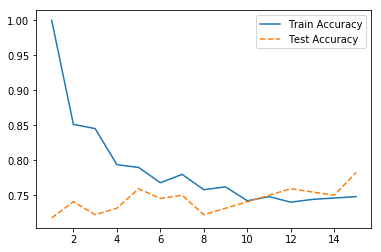

In [418]:
plt.plot(para_n_neighbors, train_accuracy, linestyle = '-', label = "Train Accuracy")
plt.plot(para_n_neighbors, test_accuracy, linestyle = '--', label = "Test Accuracy")
plt.legend()

In [419]:
train_accuracy = []; test_accuracy = []

para_n_neighbors = [i for i in range (1, 16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNN(n_neighbors = v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))
    
df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors["Neighbors"] = para_n_neighbors
df_accuracy_neighbors["TrainAccuracy"] = train_accuracy
df_accuracy_neighbors["TestAccuracy"] = test_accuracy

df_accuracy_neighbors.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys
/home/pirl/anaconda3/lib/pyt

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.718
1,2,0.851,0.741
2,3,0.845,0.722
3,4,0.794,0.731
4,5,0.790,0.759
5,6,0.768,0.745
6,7,0.780,0.750
7,8,0.758,0.722
8,9,0.762,0.731
9,10,0.742,0.741


In [420]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')